统计分析, all use swarm A(, all choose b_E,E_north?)

# 导入

In [1]:
import os.path
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import spectrogram
from spacepy import coordinates as coord
from spacepy.time import Ticktock
from geopack import geopack

from configs import ProjectConfigs
from pyaw.utils import spectral
from pyaw.utils.plot import plot_multi_panel, plot_gridded_panels
from utils import histogram2d, coordinate
from utils.orbit import get_nor_sou_split_indices_swarm_dmsp
from utils.other import (
    OutlierData,
    interpolate_missing,
    align_high2low,
    get_3arrs,
)

from pyaw.parameters import (
    PhysicalParameters,
    calculate_lower_bound,
    calculate_upper_bound,
    calculate_R,
    calculate_phase_vary_range,
)

Load IGRF coefficients ...


# 基本变量设置

In [2]:
swarm_type = "A"

radius = 6816838.5*1e-3  # km
Re = 6371.2  # km
altitude0 = radius - Re  # km（初始高度）

data_dir_path_mag_hr = r"V:\aw\swarm\vires\measurements\SW_OPER_MAGA_HR_1B"
data_dir_path__mag_hr_igrf = r"V:\aw\swarm\vires\igrf\SW_OPER_MAGA_HR_1B"
data_dir_path_tct16 = r"V:\aw\swarm\vires\measurements\SW_EXPT_EFIA_TCT16"
data_dir_path_tct16_aux = r"V:\aw\swarm\vires\auxiliaries\SW_EXPT_EFIA_TCT16"

fs = 16
window = "hann"
spectrogram_window_seconds = 4

plt.style.use("seaborn-v0_8-paper")

cpsd_m_threshold = 0.3
num_bins = 50

mu0 = PhysicalParameters.mu0
Sigma_P_dy = 3.0
Sigma_P_sta = 0.5
va_dy = 1.4e6
va_sta = 1.3e6

boundary_l_dy = calculate_lower_bound(Sigma_P_dy)
boundary_h_dy = calculate_upper_bound(va_dy, Sigma_P_dy)
print(f"boundary_l_dy*mu0: {boundary_l_dy * mu0}")
print(f"boundary_h_dy*mu0: {boundary_h_dy * mu0}")

boundary_l_sta = calculate_lower_bound(Sigma_P_sta)
boundary_h_sta = calculate_upper_bound(va_sta, Sigma_P_sta)
print(f"boundary_l_sta*mu0: {boundary_l_sta * mu0}")
print(f"boundary_h_sta*mu0: {boundary_h_sta * mu0}")

reflection_coef_dy = calculate_R(v_A=va_dy, Sigma_P=Sigma_P_dy)
reflection_coef_sta = calculate_R(v_A=va_sta, Sigma_P=Sigma_P_sta)

phase_vary_range_dy = calculate_phase_vary_range(reflection_coef_dy)
phase_vary_range_sta = calculate_phase_vary_range(reflection_coef_sta)
print(f"phase_vary_range_dy: {phase_vary_range_dy}")
print(f"phase_vary_range_sta: {phase_vary_range_sta}")

boundary_l_dy*mu0: 0.3333333333333333
boundary_h_dy*mu0: 9.28532381410286
boundary_l_sta*mu0: 2.0
boundary_h_sta*mu0: 1.3343705141015165
phase_vary_range_dy: (68.54267010140487, -68.54267010140487)
phase_vary_range_sta: (-11.515132136491069, 11.515132136491069)


# 用于研究的所有轨道号

根据100个阿尔芬波事件做统计，至少需要50轨数据。接下来从第一个电磁观测数据都有（主要是tct16有些轨道没有数据）的轨道12728开始（注意由于地磁亚暴事件事件列表的限制，轨道应从2016年3、4、6月中）统计所有用于研究的轨道号。具体轨道号见obsidian文档。

# 轨道12728

## read and process data

In [3]:
# file_names
file_name_mag_hr = "SW_OPER_MAGA_HR_1B_12728_20160301T012924_20160301T030258.pkl"
file_name_mag_hr_igrf = "IGRF_SW_OPER_MAGA_HR_1B_12728_20160301T012924_20160301T030258.pkl"
file_name_tct16 = "SW_EXPT_EFIA_TCT16_12728_20160301T012924_20160301T030258.pkl"
file_name_tct16_aux = "aux_SW_EXPT_EFIA_TCT16_12728_20160301T012924_20160301T030258.pkl"

In [4]:
# get orbit number and orbit start time and time for the latter cases save to xlsx filename
base_name = os.path.splitext(file_name_mag_hr)[0]
parts = base_name.split('_')
file_orbit_number = parts[-3]
file_start_time = parts[-2]
file_end_time = parts[-1]

In [5]:
# file paths
file_path_mag_hr = os.path.join(data_dir_path_mag_hr, file_name_mag_hr)
file_path_mag_hr_igrf = os.path.join(data_dir_path__mag_hr_igrf, file_name_mag_hr_igrf)
file_path_tct16 = os.path.join(data_dir_path_tct16, file_name_tct16)
file_path_tct16_aux = os.path.join(data_dir_path_tct16_aux, file_name_tct16_aux)

In [6]:
# read data as df
df_b = pd.read_pickle(file_path_mag_hr)
df_b_igrf = pd.read_pickle(file_path_mag_hr_igrf)
df_e = pd.read_pickle(file_path_tct16)
df_e_aux = pd.read_pickle(file_path_tct16_aux)

In [7]:
# clip data from north and south and all abs greater than 50
lats_b = df_b["Latitude"].values
lats_e = df_e["Latitude"].values


indices_b = get_nor_sou_split_indices_swarm_dmsp(lats_b)
indices_e = get_nor_sou_split_indices_swarm_dmsp(lats_e)

nor_slice_b = slice(*indices_b[0])
sou_slice_b = slice(*indices_b[1])

nor_slice_e = slice(*indices_e[0])
sou_slice_e = slice(*indices_e[1])

# get clip df by hemisphere
df_b_nor = df_b.iloc[nor_slice_b]
df_b_sou = df_b.iloc[sou_slice_b]

df_b_igrf_nor = df_b_igrf.iloc[nor_slice_b]
df_b_igrf_sou = df_b_igrf.iloc[sou_slice_b]

df_e_nor = df_e.iloc[nor_slice_e]
df_e_sou = df_e.iloc[sou_slice_e]

df_e_aux_nor = df_e_aux.iloc[nor_slice_e]
df_e_aux_sou = df_e_aux.iloc[sou_slice_e]

In [8]:
# get np.abs(lat)>50 clip df

df_b_nor = df_b_nor[df_b_nor['Latitude']>50].copy()
df_b_sou = df_b_sou[df_b_sou['Latitude']<-50].copy()

df_b_igrf_nor = df_b_igrf_nor[df_b_igrf_nor['Latitude']>50].copy()
df_b_igrf_sou = df_b_igrf_sou[df_b_igrf_sou['Latitude']<-50].copy()

df_e_nor = df_e_nor[df_e_nor['Latitude']>50].copy()
df_e_sou = df_e_sou[df_e_sou['Latitude']<-50].copy()

df_e_aux_nor = df_e_aux_nor[df_e_aux_nor['Latitude']>50].copy()
df_e_aux_sou = df_e_aux_sou[df_e_aux_sou['Latitude']<-50].copy()

# for robust
assert np.array_equal(df_b_nor.index.values,df_b_igrf_nor.index.values)
assert np.array_equal(df_b_sou.index.values,df_b_igrf_sou.index.values)

assert np.array_equal(df_e_nor.index.values,df_e_aux_nor.index.values)
assert np.array_equal(df_e_sou.index.values,df_e_aux_sou.index.values)

## north

### 初始化变量

In [9]:
hemisphere = "N"

### some basic info

In [10]:
latitudes = df_e_nor["Latitude"].values
longitudes = df_e_nor["Longitude"].values
qdlats = df_e_aux_nor["QDLat"].values
mlts = df_e_aux_nor["MLT"].values  # mlt

In [11]:
# process b

Ehx = df_e_nor["Ehx"].values
Ehx_outlier = OutlierData.set_outliers_nan_std(Ehx, 1, print_=True)
Ehx_outlier_interp = interpolate_missing(Ehx_outlier, df_e_nor.index.values)

Ehy = df_e_nor["Ehy"].values
Ehy_outlier = OutlierData.set_outliers_nan_std(Ehy, 1, print_=True)
Ehy_outlier_interp = interpolate_missing(Ehy_outlier, df_e_nor.index.values)

VsatN = df_e_nor["VsatN"].values
VsatE = df_e_nor["VsatE"].values

rotmat_nec2sc, rotmat_sc2nec = coordinate.NEC2SCandSC2NEC.get_rotmat_nec2sc_sc2nec(
    VsatN, VsatE
)
E_north, E_east = coordinate.NEC2SCandSC2NEC.do_rotation(
    -Ehx_outlier_interp, -Ehy_outlier_interp, rotmat_sc2nec
)

Outliers detected: 3168
Outlier values: [ 19.52278  -24.115065 -28.44335  ...  15.796964  39.345196  42.49999 ]
Outliers detected: 4106
Outlier values: [-11.42038  -13.670117  43.43474  ... -11.36417   54.772545 -19.450413]


In [12]:
# process b

B_N, B_E, _ = get_3arrs(df_b_nor["B_NEC"].values)
B_N_IGRF, B_E_IGRF, _ = get_3arrs(df_b_igrf_nor["B_NEC_IGRF"].values)
b_E = B_E - B_E_IGRF
b_N = B_N - B_N_IGRF

In [13]:
# align datetimes
datetimes_e = df_e_nor.index.values
datetimes_b = df_b_nor.index.values
b_E = align_high2low(b_E, datetimes_b, datetimes_e)
b_N = align_high2low(b_N, datetimes_b, datetimes_e)

In [14]:
# base datetimes
datetimes = datetimes_e
dt = datetime.fromisoformat(str(datetimes[0]))
start_time = dt.strftime("%Y%m%dT%H%M%S")
dt = datetime.fromisoformat(str(datetimes[-1]))
end_time = dt.strftime("%Y%m%dT%H%M%S")

## spectrogram

In [15]:
nperseg=int(spectrogram_window_seconds*fs)
frequencies, ts, Sxx_b = spectrogram(
    b_E,
    fs=fs,
    window=window,
    nperseg=nperseg,
    mode="complex",
)
_, _, Sxx_e = spectrogram(
    E_north, fs=fs, window=window, nperseg=nperseg, mode="complex"
)
ts_dt64 = datetimes[0] + [np.timedelta64(int(_), "s") for _ in ts]
cpsd = Sxx_e * np.conj(Sxx_b)

## coherency

In [16]:
segment_length_sec = 4  # 越大最后得到的数组的长度越小，取和之前的spectrogram输入的窗口长度是一个不错的选择
try:
    mid_times_all, avg_complex_coh = spectral.calculate_segmented_complex_coherency(
        datetimes,
        b_E,
        E_north,
        fs=fs,
        segment_length_sec=segment_length_sec,
        nfft_coh=int(
            fs * segment_length_sec * 0.5
        ),  # Use segment_length_sec/2 second FFT within segments
    )
    # Extract magnitude and phase from the complex result
    avg_coh_magnitude = np.abs(avg_complex_coh)

except ValueError as e:
    print(f"Error calculating Coherency: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

## 开始通过相关图像确定Region

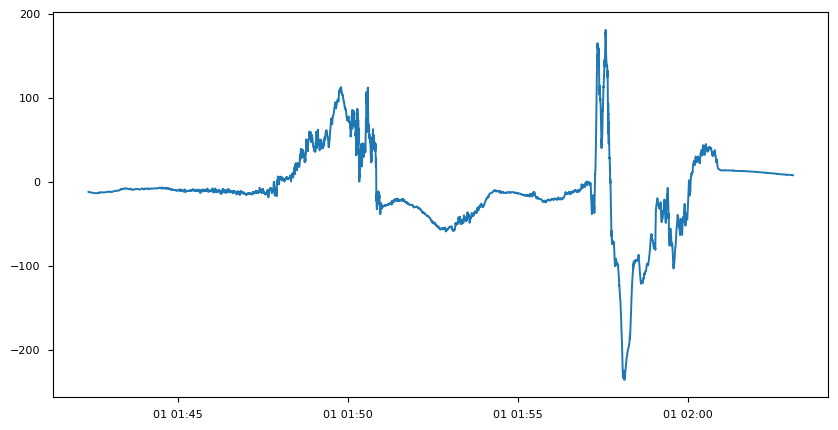

In [17]:
# b
figsize = (10,5)
plt.figure(figsize=figsize)
plt.plot(datetimes,b_E)
plt.show()

### preset region parameters for plot annoatations, labels and so on

In [18]:
# 1
# st_dy = np.datetime64("2016-03-01 01:50:00")
# et_dy = np.datetime64("2016-03-01 01:50:20")
# not

# 2
st_dy = np.datetime64("2016-03-01 01:57:20")
et_dy = np.datetime64("2016-03-01 01:57:40")
# yes

st_sta = np.datetime64("2016-03-01 01:45:00")
et_sta = np.datetime64("2016-03-01 01:46:00")

# define plot

subplot_defs = [
    {
        "plot_type": "line",
        "x_data": datetimes,
        "y_data": b_E,
        "label": r"$\Delta B_{East}$",
        "title": "East Component of Disturb Magnetic Field",
        "ylabel": "Magnetic Flux Density (nT)",
        "linewidth": 1.8,
    },  # Slightly thicker line
    {
        "plot_type": "line",
        "x_data": datetimes,  # Assuming same time base for E-field line plot
        "y_data": E_north,
        "label": r"$E_{North}$",
        "title": "Northward Component of Electric Field",
        "ylabel": "Electric Field Strength (mV/m)",
        "linewidth": 1.8,
    },
    {
        "plot_type": "pcolormesh",
        "x_data": ts_dt64,
        "y_data": frequencies,
        "z_data": 10 * np.log10(np.abs(Sxx_b)),
        "title": "Power Spectral Density of East Component of Disturb Magnetic Field",
        "ylabel": "Frequency (Hz)",
        "clabel": r"$10log_{10}(S_{bb}(f,t))$",
        "shading": "gouraud",
        # "vmin": -10,
        # "vmax": 10,
        # 'cmap': 'plasma' # Example local override
    },
    {
        "plot_type": "pcolormesh",
        "x_data": ts_dt64,
        "y_data": frequencies,
        "z_data": 10 * np.log10(np.abs(Sxx_e)),
        "title": "Power Spectral Density of Northward Component of Electric Field",
        "ylabel": "Frequency (Hz)",
        "clabel": r"$10log_{10}(S_{EE}(f,t))$",
        "shading": "gouraud",
        # "vmin": -10,
        # "vmax": 10,
    },
    {
        "plot_type": "pcolormesh",
        "x_data": ts_dt64,
        "y_data": frequencies,
        "z_data": 10 * np.log10(np.abs(cpsd)),
        "title": r"The Module of Cross Power Spectral Density of $\Delta B_{East}$ and $E_{North}$",
        "ylabel": "Frequency (Hz)",
        "clabel": r"$10log_{10}(S_{Eb}(f,t))$",
        "shading": "gouraud",
        # "vmin": -10,
        # "vmax": 10,
        # 'vmin': -50 # Example local override for clim
    },
    {
        "plot_type": "line",
        "x_data": mid_times_all,
        "y_data": avg_coh_magnitude,
        "label": r"Coherency",
        "title": "Coherency of $\Delta B_{East}$ and $E_{North}$",
        "ylabel": "Coherency (Unit 1)",
        "linewidth": 1.8,
    },
]

# add labels, annotations ...

for subplot_def in subplot_defs[:2]:
    subplot_def["blocks"] = [
        {
            "start": st_sta,
            "end": et_sta,
            "color": "#004488",
            "label": "Static Region",
        },
        {
            "start": st_dy,
            "end": et_dy,
            "color": "#DDAA33",
            "label": "Dynamic Region",
        },
    ]
for subplot_def in subplot_defs[2:-1]:
    subplot_def["vlines"] = {
        "Static Region Start": st_sta,
        "Static Region End": et_sta,
        "Dynamic Region Start": st_dy,
        "Dynamic Region End": et_dy,
    }
subplot_defs[-1]["blocks"] = [
    {
        "start": st_sta,
        "end": et_sta,
        "color": "#004488",
        "label": "Static Region",
    },
    {
        "start": st_dy,
        "end": et_dy,
        "color": "#DDAA33",
        "label": "Dynamic Region",
    },
]
subplot_defs[-1]["hlines"] = [{"y": 0.5, "color": "magenta", "linestyle": "-."}]

# Define Aux Data for X labels
aux_data_for_x = {"Lat": latitudes, "MLT": mlts}

### 1st plot

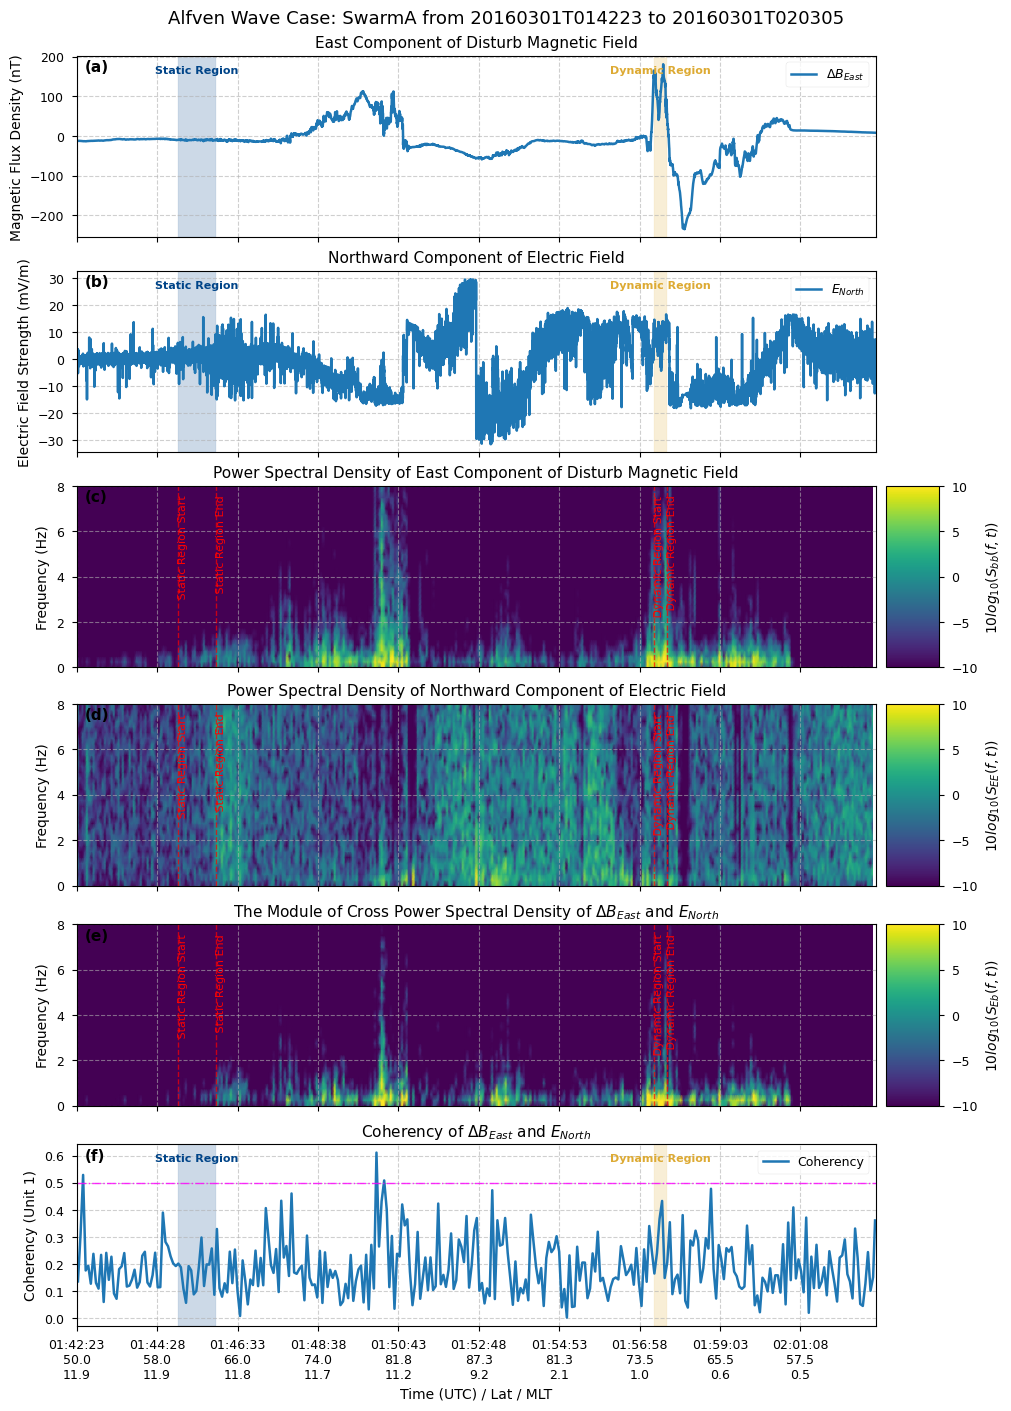

In [19]:
# Call the function to plot
x_label_step=2000
fig, axes = plot_multi_panel(
    subplot_definitions=subplot_defs,
    x_datetime_ref=datetimes,  # Reference times for aux data (note that lats,mlts based on datetimes not tsdt64)
    x_aux_data=aux_data_for_x,  # The aux data arrays
    x_label_step=x_label_step,  # Show label every N points
    figsize=(10, 14),
    figure_title=f"Alfven Wave Case: Swarm{swarm_type} from {start_time} to {end_time}",
    # global_cmap=matplotlib.rcParams["image.cmap"],  # default
    global_cmap="viridis",
    global_vmin=-10,  # Example: Manually set global limits
    global_vmax=10,
    use_shared_clims=True,  # Use calculated shared limits unless overridden
    rotate_xticklabels=0,  # Keep horizontal for concise formatter
    # font size
    title_fontsize=11,
    label_fontsize=10,
    tick_label_fontsize=9,
    legend_fontsize=9,
    annotation_fontsize=8,
    panel_label_fontsize=11,  # Control (a), (b)... size
)
plt.show()

### 2nd plot

In [20]:
# dy
t_mask_dy = (datetimes >= st_dy) & (datetimes <= et_dy)
datetimes_dy = datetimes[t_mask_dy]
b_E_dy = b_E[t_mask_dy]
E_north_dy = E_north[t_mask_dy]

# sta
t_mask_sta = (datetimes >= st_sta) & (datetimes <= et_sta)
datetimes_sta = datetimes[t_mask_sta]
b_E_sta = b_E[t_mask_sta]
E_north_sta = E_north[t_mask_sta]

### get key variables value

In [21]:
latitudes_dy = latitudes[t_mask_dy]
start_lat_dy = latitudes_dy[0]
end_lat_dy = latitudes_dy[-1]

longitudes_dy = longitudes[t_mask_dy]
start_lon_dy = longitudes_dy[0]
end_lon_dy = longitudes_dy[-1]

qdlats_dy = qdlats[t_mask_dy]
start_qdlats_dy = qdlats_dy[0]
end_qdlats_dy = qdlats_dy[-1]

mlts_dy = mlts[t_mask_dy]
start_mlts_dy = mlts_dy[0]
end_mlts_dy = mlts_dy[-1]

In [22]:
nperseg_sec = spectrogram_window_seconds
nperseg_psd = int(nperseg_sec * fs)  # same as the 1st spectrogram nperseg

delta_B_E_align_dy_psd = spectral.PSD(
    b_E_dy,
    fs=fs,
    nperseg=nperseg_psd,
    window=window,
    scaling="density",
)  # same arguments setting as spectrogram
E_north_dy_psd = spectral.PSD(
    E_north_dy,
    fs=fs,
    nperseg=nperseg_psd,
    window=window,
    scaling="density",
)
delta_B_E_align_sta_psd = spectral.PSD(
    b_E_sta,
    fs=fs,
    nperseg=nperseg_psd,
    window=window,
    scaling="density",
)
E_north_sta_psd = spectral.PSD(
    E_north_sta,
    fs=fs,
    nperseg=nperseg_psd,
    window=window,
    scaling="density",
)

frequencies_psd_dy, Pxx_delta_B_E_align_dy = delta_B_E_align_dy_psd.get_psd()
_, Pxx_E_north_dy = E_north_dy_psd.get_psd()
frequencies_psd_sta, Pxx_delta_B_E_align_sta = delta_B_E_align_sta_psd.get_psd()
_, Pxx_E_north_sta = E_north_sta_psd.get_psd()

In [23]:
spectrogram_window_seconds_region = 4  # compare to the former spectrogram 4
nperseg = int(spectrogram_window_seconds_region * fs)

frequencies_spec_dy, ts_dy, Sxx_b_dy = spectrogram(
    b_E_dy,
    fs=fs,
    window=window,
    nperseg=nperseg,
    mode="complex",
)

_, _, Sxx_e_dy = spectrogram(
    E_north_dy, fs=fs, window=window, nperseg=nperseg, mode="complex"
)

frequencies_spec_sta, ts_sta, Sxx_b_sta = spectrogram(
    b_E_sta,
    fs=fs,
    window=window,
    nperseg=nperseg,
    mode="complex",
)
_, _, Sxx_e_sta = spectrogram(
    E_north_sta,
    fs=fs,
    window=window,
    nperseg=nperseg,
    mode="complex",
)

ts_dt64_dy = datetimes_dy[0] + [np.timedelta64(int(_), "s") for _ in ts_dy]
ts_dt64_sta = datetimes_sta[0] + [np.timedelta64(int(_), "s") for _ in ts_sta]

cpsd_dy = Sxx_e_dy * np.conj(Sxx_b_dy)
cpsd_sta = Sxx_e_sta * np.conj(Sxx_b_sta)

In [24]:
cpsd_phase_dy = np.degrees(np.angle(cpsd_dy))
cpsd_m_dy = np.abs(cpsd_dy)
cpsd_phase_dy[cpsd_m_dy < cpsd_m_threshold] = np.nan  # threshold
phase_bins_dy, phase_histogram2d_dy = histogram2d.get_phase_histogram2d(
    frequencies_spec_dy, cpsd_phase_dy, num_bins=num_bins
)

cpsd_phase_sta = np.degrees(np.angle(cpsd_sta))
cpsd_m_sta = np.abs(cpsd_sta)
cpsd_phase_sta[cpsd_m_sta < cpsd_m_threshold] = np.nan  # threshold
phase_bins_sta, phase_histogram2d_sta = histogram2d.get_phase_histogram2d(
    frequencies_spec_sta, cpsd_phase_sta, num_bins=num_bins
)

In [25]:
eb_ratio_psd_dy = (
    (Pxx_E_north_dy / Pxx_delta_B_E_align_dy) * 1e-3 * 1e9
)  # transform unit
eb_ratio_psd_sta = (Pxx_E_north_sta / Pxx_delta_B_E_align_sta) * 1e-3 * 1e9

In [26]:
nrows, ncols_main = 4, 2
plot_defs = [[None for _ in range(ncols_main)] for _ in range(nrows)]
# Row 0
plot_defs[0][0] = {
    "plot_type": "line",
    "x_data": datetimes_sta,
    "y_data_list": [
        E_north_sta,
        b_E_sta,
    ],  # 先用蓝色绘制电场，在用橙色绘制磁场
    "linewidth": 1.8,
    "labels": [r"$E_{North}$", r"$\Delta {B_{East}}$"],
    "title": f"Static Region from\n{st_sta} to {et_sta}",
    "xlabel": "Time (UTC)",
    "ylabel": "Amplitude",
}
plot_defs[0][1] = {
    "plot_type": "line",
    "x_data": datetimes_dy,
    "y_data_list": [E_north_dy, b_E_dy],
    "labels": [r"$E_{North}$", r"$\Delta {B_{East}}$"],
    "title": f"Dynamic Region from\n{st_dy} to {et_dy}",
    "xlabel": "Time (UTC)",
    "ylabel": "Amplitude",
}
# Row 1
plot_defs[1][0] = {
    "plot_type": "line",
    "x_data": frequencies_psd_sta,
    "y_data_list": [Pxx_E_north_sta, Pxx_delta_B_E_align_sta],
    "labels": [r"PSD of $\Delta {B_{East}}$", r"PSD of $E_{North}$"],
    "yscale": "log",  # Use log scale
    "title": "PSD of $\Delta {B_{East}}$ and $E_{North}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "PSD",
}
plot_defs[1][1] = {
    "plot_type": "line",
    "x_data": frequencies_psd_dy,
    "y_data_list": [Pxx_E_north_dy, Pxx_delta_B_E_align_dy],
    "labels": [r"PSD of $\Delta {B_{East}}$", r"PSD of $E_{North}$"],
    "yscale": "log",  # Use log scale
    "title": "PSD of $\Delta {B_{East}}$ and $E_{North}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "PSD",
}
# Row 2
plot_defs[2][0] = {
    "plot_type": "line",
    "x_data": frequencies_psd_sta,
    "y_data_list": [eb_ratio_psd_sta],
    "yscale": "log",  # Use log scale
    "labels": [r"ratio $\frac{E_{North}}{\Delta {B_{East}}}$"],
    "title": r"ratio $\frac{E_{North}}{\Delta {B_{East}}}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "ratio",
    "hlines": [
        {"y": boundary_l_sta},
        {
            "y": boundary_h_sta,
        },
        {"y": va_sta, "label": r"$v_A$"},
    ],
}
plot_defs[2][1] = {
    "plot_type": "line",
    "x_data": frequencies_psd_dy,
    "y_data_list": [eb_ratio_psd_dy],
    "yscale": "log",
    "labels": [r"ratio $\frac{E_{North}}{\Delta {B_{East}}}$"],
    "title": r"ratio $\frac{E_{North}}{\Delta {B_{East}}}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "ratio",
    "hlines": [
        {"y": boundary_l_dy},
        {
            "y": boundary_h_dy,
        },
        {"y": va_dy, "label": r"$v_A$"},
    ],
}  # Normal line plot here
# Row 3
plot_defs[3][0] = {
    "plot_type": "pcolormesh",
    "x_data": frequencies_spec_sta,
    "y_data": (phase_bins_sta[:-1] + phase_bins_sta[1:]) / 2,
    "z_data": phase_histogram2d_sta.T,
    "title": "The Occurrence of Phase Difference between\n$\Delta {B_{East}}$ and $E_{North}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "Phase Difference (Degree)",
    "shading": "auto",
    "hlines": [{"y": phase_vary_range_sta[0]}, {"y": phase_vary_range_sta[1]}],
}
plot_defs[3][1] = {
    "plot_type": "pcolormesh",
    "x_data": frequencies_spec_dy,
    "y_data": (phase_bins_dy[:-1] + phase_bins_dy[1:]) / 2,
    "z_data": phase_histogram2d_dy.T,
    "title": "The Occurrence of Phase Difference between\n$\Delta {B_{East}}$ and $E_{North}$",
    "xlabel": "Frequency (Hz)",
    "ylabel": "Phase Difference (Degree)",
    "shading": "auto",
    "hlines": [{"y": phase_vary_range_dy[0]}, {"y": phase_vary_range_dy[1]}],
}

Calculating shared color limits...
 Calculated shared vmin=0.00, vmax=1.00 (raw data)


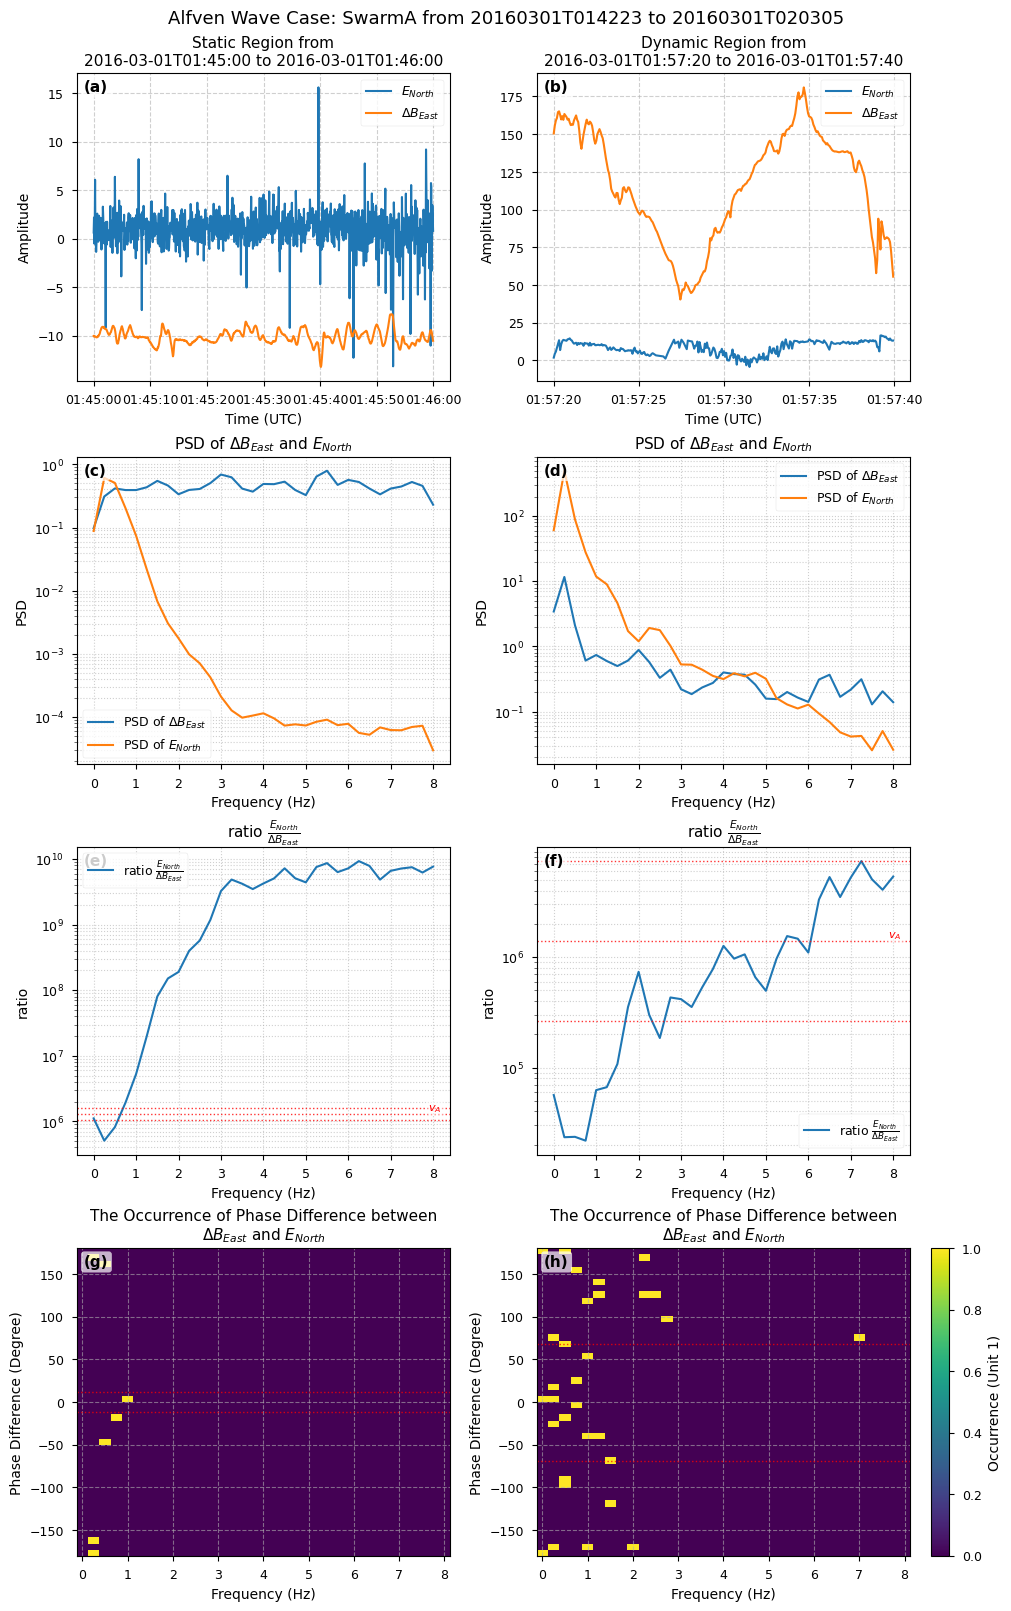

In [27]:
fig, axes = plot_gridded_panels(
    plot_definitions=plot_defs,
    nrows=4,
    ncols_main=2,
    add_shared_cbar=True,
    shared_cbar_label="Occurrence (Unit 1)",
    figure_title=f"Alfven Wave Case: Swarm{swarm_type} from {start_time} to {end_time}",
    figsize=(10, 16),  # Adjust size
    use_shared_clims=True,  # Use shared clim for spectrograms
    title_fontsize=11,
    label_fontsize=10,
    tick_label_fontsize=9,
    legend_fontsize=9,
    annotation_fontsize=8,
    panel_label_fontsize=11,
)
plt.show()

### save cases infos

#### 磁力线追踪

###### start

In [42]:
def trace_dip_auro(time:np.datetime64, alt0, lat0, lon0, type, _hemisphere, trace_set_rlim:int=10, trace_set_maxloop:int=1000, dip_tolerance=50, auro_tolerance=20, auroral_altitude:float=110,Re=6371.2):
    """

    Args:
        alt0, lat0, lon0: position of start point. unit are km, degree, degree.
        auroral_altitude: 极光高度
        dip_tolerance: 认为共轭成功所允许的共轭点高度同起点高度之间差值的阈值，单位为km。
        trace_set_rlim: set big number for more step. usually trace() not exceed "maxloop"
        _hemisphere: "N" or "S"
        type: "dip" or "auro"
        time: case start time or end time

    Returns:

    """
    # unify use geo
    c = coord.Coords([(alt0 + Re) / Re, lat0, lon0], 'GEO', 'sph', ticks=Ticktock(str(time), 'ISO'))
    # convert geo2gsm
    c_gsm = c.convert('GSM','car')
    ut = time.astype('datetime64[s]').astype(np.int64)
    _ = geopack.recalc(ut)
    if type == "dip":
        if _hemisphere == "N":
            dir = 1
        elif _hemisphere == "S":
            dir = -1
        _,_,_,xx,yy,zz = geopack.trace(c_gsm.data[0,0], c_gsm.data[0,1], c_gsm.data[0,2], dir=dir,rlim=trace_set_rlim,maxloop=trace_set_maxloop)  # 寻找共轭点，由北向南 -> dir = 1
        # 追踪是追踪到地表或者达到追踪的极限停止。x1gsm,y1gsm,z1gsm为最后一个点的3个坐标；xx,yy,zz为所有追踪点的3个坐标组成的3个数组（类型为ndarray）
        # 转换坐标（点）（GSM->GEO）
        c_back = coord.Coords(np.column_stack((xx, yy, zz)), 'GSM', 'car',
                              ticks=Ticktock([str(st_dy) for _ in range(len(xx))], 'ISO'))
        c_GEO = c_back.convert('GEO','sph')  # 返回alt(km),lat(degree),'lon(degree)'
        # 寻找共轭点（另一个半球相同高度）
        idx = np.argmin(np.abs((c_GEO.data[:,0]-1) * Re - alt0))
        # 输出
        dip_alts_convert_unit = (c_GEO.data[:,0]-1)*Re
        dip_alt = dip_alts_convert_unit[idx]
        dip_lat = c_GEO.data[:,1][idx]
        dip_lon = c_GEO.data[:,2][idx]  # 不论是否追踪到另一个半球的共轭点，都输出这些信息，反正到时候和其起点的坐标一比对就知道是否达到共轭
        # get success diploma
        if (dip_lat*lat0<0) and (np.abs(dip_alt - alt0) < dip_tolerance):
            success_dip = True
        else:
            success_dip = False
        return dip_alt,dip_lat,dip_lon,success_dip
    elif type == "auro":
        if _hemisphere == "N":
            dir = -1
        elif _hemisphere == "S":
            dir = 1
        _,_,_,xx,yy,zz = geopack.trace(c_gsm.data[0,0], c_gsm.data[0,1], c_gsm.data[0,2], dir=dir,rlim=trace_set_rlim,maxloop=trace_set_maxloop)  # 北半球+轨道高度高于110km -> dir=-1
        c_back = coord.Coords(np.column_stack((xx, yy, zz)), 'GSM', 'car',
                              ticks=Ticktock([str(st_dy) for _ in range(len(xx))], 'ISO'))
        c_GEO = c_back.convert('GEO','sph')
        idx = np.argmin(np.abs((c_GEO.data[:,0]-1)*Re - auroral_altitude))
        auro_alts_convert_unit = (c_GEO.data[:,0]-1)*Re
        final_trace_alt = auro_alts_convert_unit[idx]
        auro_lat = c_GEO.data[:,1][idx]
        auro_lon = c_GEO.data[:,2][idx]
        if (np.abs(final_trace_alt-auroral_altitude) < auro_tolerance):
            success_auro = True
        else:
            success_auro = False
        return final_trace_alt,auro_lat,auro_lon,success_auro





# _test = trace_dip_auro(st_dy,"dip",hemisphere,trace_set_rlim=100,trace_set_maxloop=10000)


In [35]:

# # start
# t = Ticktock(str(st_dy), 'ISO')
# c = coord.Coords([altitude0, start_lat_dy, start_lon_dy], 'GDZ', 'sph')
# c.ticks = t
# c_gsm = c.convert('GSM','car')
#
# # trace dip
#
# ut = st_dy.astype('datetime64[s]').astype(np.int64)
# ps = geopack.recalc(ut)
# x1gsm_dip,y1gsm_dip,z1gsm_dip,xx_dip,yy_dip,zz_dip = geopack.trace(c_gsm.data[0,0], c_gsm.data[0,1], c_gsm.data[0,2], dir=1)  # 寻找共轭点，由北向南 -> dir = 1
# # 追踪是追踪到地表或者达到追踪的极限停止。x1gsm,y1gsm,z1gsm为最后一个点的3个坐标；xx,yy,zz为所有追踪点的3个坐标组成的3个数组（类型为ndarray）
#
# # 转换坐标（点）（GSM->GEO）
# c_back = coord.Coords(np.column_stack((xx_dip, yy_dip, zz_dip)), 'GSM', 'car')
# dip_t_back = Ticktock([str(st_dy) for _ in range(len(xx_dip))], 'ISO')
# c_back.ticks = dip_t_back
#
# c_GEO = c_back.convert('GEO','sph')  # 返回alt(km),lat(degree),'lon(degree)'
# # 寻找共轭点（另一个半球相同高度）

In [36]:
# idx = np.argmin(np.abs((c_GEO.data[:,0]-1)*Re - altitude0))
# # 输出
# dip_alts_convert_unit = (c_GEO.data[:,0]-1)*Re
# start_dip_alt = dip_alts_convert_unit[idx]
# start_dip_lat = c_GEO.data[:,1][idx]
# start_dip_lon = c_GEO.data[:,2][idx]

In [29]:
# # trace 110km aurora
# x1gsm_auro,y1gsm_auro,z1gsm_auro,xx_auro,yy_auro,zz_auro = geopack.trace(c_gsm.data[0,0], c_gsm.data[0,1], c_gsm.data[0,2], dir=-1)  # 北半球+轨道高度高于110km -> dir=-1
# # 转换坐标（点）（GSM->GEO）
# c_back = coord.Coords(np.column_stack((xx_auro,yy_auro,zz_auro)), 'GSM', 'car')
# auro_t_back = Ticktock([str(st_dy) for _ in range(len(xx_auro))], 'ISO')
# c_back.ticks = auro_t_back
# c_GEO = c_back.convert('GEO','sph')
# # 寻找追踪到对应极光高度对应的点
# idx = np.argmin(np.abs((c_GEO.data[:,0]-1)*Re - altitude0))  # todo：插值提高精度？
# # 输出
# auro_alts_convert_unit = (c_GEO.data[:,0]-1)*Re
# start_auro_alt = auro_alts_convert_unit[idx]
# start_auro_lat = c_GEO.data[:,1][idx]
# start_auro_lon = c_GEO.data[:,2][idx]

##### end

In [30]:
# t = Ticktock(str(et_dy), 'ISO')
# c = coord.Coords([altitude0, end_lat_dy, end_lon_dy], 'GDZ', 'sph')
# c.ticks = t
# c_gsm = c.convert('GSM','car')

# trace dip

# ut = et_dy.astype('datetime64[s]').astype(np.int64)
# ps = geopack.recalc(ut)
# x1gsm_dip,y1gsm_dip,z1gsm_dip,xx_dip,yy_dip,zz_dip = geopack.trace(c_gsm.data[0,0], c_gsm.data[0,1], c_gsm.data[0,2], dir=1)  # 寻找共轭点，由北向南 -> dir = 1
# # 追踪是追踪到地表或者达到追踪的极限停止。x1gsm,y1gsm,z1gsm为最后一个点的3个坐标；xx,yy,zz为所有追踪点的3个坐标组成的3个数组（类型为ndarray）

# # 转换坐标（点）（GSM->GEO）
# c_back = coord.Coords(np.column_stack((xx_dip, yy_dip, zz_dip)), 'GSM', 'car')
# dip_t_back = Ticktock([str(et_dy) for _ in range(len(xx_dip))], 'ISO')
# c_back.ticks = dip_t_back
#
# c_GEO = c_back.convert('GEO','sph')  # 返回alt(km),lat(degree),'lon(degree)'
# # 寻找共轭点（另一个半球相同高度）
# idx = np.argmin(np.abs((c_GEO.data[:,0]-1)*Re - altitude0))
# # 输出
# dip_alts_convert_unit = (c_GEO.data[:,0]-1)*Re
# end_dip_alt = dip_alts_convert_unit[idx]
# end_dip_lat = c_GEO.data[:,1][idx]
# end_dip_lon = c_GEO.data[:,2][idx]

In [ ]:
# # trace 110km aurora
# x1gsm_auro,y1gsm_auro,z1gsm_auro,xx_auro,yy_auro,zz_auro = geopack.trace(c_gsm.data[0,0], c_gsm.data[0,1], c_gsm.data[0,2], dir=-1)  # 北半球+轨道高度高于110km -> dir=-1
# # 转换坐标（点）（GSM->GEO）
# c_back = coord.Coords(np.column_stack((xx_auro,yy_auro,zz_auro)), 'GSM', 'car')
# auro_t_back = Ticktock([str(et_dy) for _ in range(len(xx_auro))], 'ISO')
# c_back.ticks = auro_t_back
# c_GEO = c_back.convert('GEO','sph')
# # 寻找追踪到对应极光高度对应的点
# idx = np.argmin(np.abs((c_GEO.data[:,0]-1)*Re - altitude0))  # todo：插值提高精度？
# # 输出
# auro_alts_convert_unit = (c_GEO.data[:,0]-1)*Re
# end_auro_alt = auro_alts_convert_unit[idx]
# end_auro_lat = c_GEO.data[:,1][idx]
# end_auro_lon = c_GEO.data[:,2][idx]

### save

In [28]:
save = False
save_dir = r"G:\master\pyaw\scripts\results\aw_cases"

def save2pkl(_save_path=None):
    # 初始化字典
    cases_dic = {}
    # 单个事件的关键数据组成的字典
    case_data = {
        "start_time":st_dy,
        "end_time":et_dy,
        "hemisphere":hemisphere,
        "start_latitude":start_lat_dy,
        "end_latitude":end_lat_dy,
        "start_longitude":start_lon_dy,
        "end_longitude":end_lon_dy,
        "start_qdlats":start_qdlats_dy,
        "end_qdlats":end_qdlats_dy,
        "start_mlt":start_mlts_dy,
        "end_mlt":end_mlts_dy,
        "start_dip_alt":start_dip_alt,
        "end_dip_alt":end_dip_alt,
        "start_dip_lat":start_dip_lat,
        "end_dip_lat":end_dip_lat,
        "start_dip_lon":start_dip_lon,
        "end_dip_lon":end_dip_lon,
        "start_auro_alt":start_auro_alt,
        "end_auro_alt":end_auro_alt,
        "start_auro_lat":start_auro_lat,
        "end_auro_lat":end_auro_lat,
        "start_auro_lon":start_auro_lon,
        "end_auro_lon":end_auro_lon,
    }
    df = pd.DataFrame(data=case_data)
    if _save_path is not None:
        df.to_pickle(_save_path)

def parse_dt64(time):
    dt64 = datetime.fromisoformat(str(time))
    return dt64.strftime("%Y%m%dT%H%M%S")

if save:
    format_st_dy = parse_dt64(st_dy)
    format_et_dy = parse_dt64(et_dy)
    save_name = f"{file_orbit_number}_case_{format_st_dy}_{format_et_dy}.pkl"
    save_path = os.path.join(save_dir,save_name)
    save2pkl(_save_path=save_path)